# Xây dựng hệ thống gợi ý phim 

## 1. Chuẩn bị dữ liệu

Tải các thư viện cần thiết.

In [1]:
# Thư viện để tạo SparkSession, điểm khởi đầu cho PySpark
from pyspark.sql import SparkSession
# Thư viện cung cấp hàm col để tham chiếu và xử lý các cột trong DataFrame
from pyspark.sql.functions import col
# Thư viện cung cấp các hàm xử lý dữ liệu cho DataFrame
from pyspark.sql import functions as F

# Thư viện xử lý các mảng (array), đại số tuyến tính, thống kê, và các phép toán khoa học khác.
import numpy as np
# Hàm sqrt (tính căn bậc hai) từ module math,
from math import sqrt
# Thư viện vẽ đồ thị và trực quan hóa dữ liệu
import matplotlib.pyplot as plt

# Thư viện đánh giá mô hình hồi quy sử dụng các chỉ số như RMSE (Root Mean Square Error)
from pyspark.ml.evaluation import RegressionEvaluator
# Thuật toán ALS (Alternating Least Squares) để xây dựng hệ thống gợi ý cho dữ liệu người dùng và phim
from pyspark.ml.recommendation import ALS
# Thư viện chuyển đổi các giá trị chuỗi thành chỉ số số học cho các cột phân loại
from pyspark.ml.feature import StringIndexer

Tạo SparkSession mang tên "_Recommender System using ALS_", kết nối đến datawarehouse (datawarehouse.duckdb) thông qua trình điều khiển JDBC DuckDB.

In [2]:
# Đường dẫn đến trình điều khiển JDBC DuckDB (tệp JAR)
duck_db_jdbc = "/home/diin/HocKi_7/DE_project/duckdb_jdbc-1.1.3.jar"
# Tạo SparkSession
spark = SparkSession.builder \
    .appName("Recommender System using ALS and SGD") \
    .config("spark.jars", duck_db_jdbc) \
    .getOrCreate()

# Đường dẫn của Datawarehouse
datawarehouse_path ='/home/diin/HocKi_7/DE_project/warehouse/datawarehouse.duckdb'

# Kết nối Spark với Datawarehouse
jdbc_url = f"jdbc:duckdb:{datawarehouse_path}"

24/12/24 15:34:28 WARN Utils: Your hostname, diin resolves to a loopback address: 127.0.1.1; using 192.168.1.26 instead (on interface wlo1)
24/12/24 15:34:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/12/24 15:34:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Lấy 2 bảng dữ liệu với bảng rating sẽ được dùng để huấn luyện mô hình và bảng movie dùng để in ra thông tin của phim cho bước gợi ý phim.

In [3]:
# Tải rating_df vào Spark DataFrame
rating_df = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "(SELECT * FROM rating) AS rating") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .load()
# Tải rating_df vào Spark DataFrame
movie_df = spark.read.format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "(SELECT * FROM movie) AS movie") \
    .option("driver", "org.duckdb.DuckDBDriver") \
    .load()

Kiểm tra dữ liệu của 2 bảng đã được lấy ra 

In [4]:
# Hiển thị 10 hàng đầu tiên của DataFrame rating_df.
rating_df.show()

+--------------------+--------+----------------+--------------------+------+----+-----+---+----+
|         movie_title|movie_id|         user_id|              author|rating|year|month|day|hour|
+--------------------+--------+----------------+--------------------+------+----+-----+---+----+
|           Elemental|  976573|      msbreviews|    Manuel São Bento|  8.00|2023|    7| 20|   9|
|      Anyone But You| 1072790|    Geronimo1967|          CinemaSerf|  7.00|2023|   12| 30|  11|
|Mission: Impossib...|  575264|       mooney240|       The Movie Mob|  7.00|2023|    7| 12|   5|
|               Alien|     348|     Otokichi786|      Patrick E. Abe|  8.00|2016|    9| 21|   8|
|            Zootopia|  269149|    Geronimo1967|          CinemaSerf|  7.00|2024|    1|  2|   8|
|Terminator 2: Jud...|     280|    BryceSpencer|        BryceSpencer| 10.00|2023|    1| 29|   0|
|xXx: Return of Xa...|   47971|       Dark Jedi|  Per Gunnar Jonsson|  4.00|2017|    6| 12|  10|
|  The Little Mermaid|  447277

In [5]:
# Hiển thị 10 hàng đầu tiên của DataFrame movie_df.
movie_df.show()

+-------+--------------------+-----------------+------------+----------+----------+-------+---------------+------------+-------------+-----------+
|     id|               title|original_language|vote_average|vote_count|popularity|runtime|          genre|release_year|release_month|release_day|
+-------+--------------------+-----------------+------------+----------+----------+-------+---------------+------------+-------------+-----------+
|1000075|The Price of Mone...|               fr|         5.6|        56|   1181.32|    100|         Action|        2024|            7|         31|
|1000075|The Price of Mone...|               fr|         5.6|        56|   1181.32|    100|      Adventure|        2024|            7|         31|
|1000075|The Price of Mone...|               fr|         5.6|        56|   1181.32|    100|       Thriller|        2024|            7|         31|
| 572802|Aquaman and the L...|               en|         6.7|      2845|    120.55|    124|         Action|        202

Vì ở đây cột user_id đang có dạng "_string_" vì thế chúng ta cần chuyển thành dạng "_numeric_" để có thể huấn luyện mô hình bằng các sử dụng hàm _StringIndexer()_ và tạo ra 1 cột mới "_user_index_"

In [6]:
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_index")
rating_df = user_indexer.fit(rating_df).transform(rating_df)

Kiểm tra lại rating_df

In [7]:
rating_df.show()

+--------------------+--------+----------------+--------------------+------+----+-----+---+----+----------+
|         movie_title|movie_id|         user_id|              author|rating|year|month|day|hour|user_index|
+--------------------+--------+----------------+--------------------+------+----+-----+---+----+----------+
|           Elemental|  976573|      msbreviews|    Manuel São Bento|  8.00|2023|    7| 20|   9|       5.0|
|      Anyone But You| 1072790|    Geronimo1967|          CinemaSerf|  7.00|2023|   12| 30|  11|       0.0|
|Mission: Impossib...|  575264|       mooney240|       The Movie Mob|  7.00|2023|    7| 12|   5|      11.0|
|               Alien|     348|     Otokichi786|      Patrick E. Abe|  8.00|2016|    9| 21|   8|     128.0|
|            Zootopia|  269149|    Geronimo1967|          CinemaSerf|  7.00|2024|    1|  2|   8|       0.0|
|Terminator 2: Jud...|     280|    BryceSpencer|        BryceSpencer| 10.00|2023|    1| 29|   0|     140.0|
|xXx: Return of Xa...|   479

Vì ở "_movie_df_" các dữ liệu phim đã được tách thành các hàng để có cái nhìn rõ hơn về cột "_genre_". Nhưng hiện tại đối với "_movie_df_" chỉ sử dụng để hiển thị vì thế chúng ta sẽ gộp các dữ liệu phim lại với 

In [8]:
# Nhóm dữ liệu phim theo các cột đặc trưng, kết hợp cột thể loại và bỏ các cột không cần thiết
new_movie_df = movie_df.groupBy("id", "title", "original_language", "vote_average", "runtime", 
                       "release_year", "release_month", "release_day") \
                    .agg(F.collect_set("genre").alias("genres")) \
                    .drop("release_month","release_day")
new_movie_df.show()

+---+--------------------+-----------------+------------+-------+------------+--------------------+
| id|               title|original_language|vote_average|runtime|release_year|              genres|
+---+--------------------+-----------------+------------+-------+------------+--------------------+
|  5|          Four Rooms|               en|         5.9|     98|        1995|            [Comedy]|
|  6|      Judgment Night|               en|         6.5|    109|        1993|[Thriller, Action...|
| 11|           Star Wars|               en|         8.2|    121|        1977|[Action, Adventur...|
| 12|        Finding Nemo|               en|         7.8|    100|        2003| [Animation, Family]|
| 13|        Forrest Gump|               en|         8.5|    142|        1994|[Comedy, Drama, R...|
| 14|     American Beauty|               en|         8.0|    122|        1999|             [Drama]|
| 15|        Citizen Kane|               en|         8.0|    119|        1941|    [Drama, Mystery]|


## 2. ALS model(Alternating Least Squares).

### 2.1 Huấn luyện và tạo phim gợi ý mô hình.

Xác định tỷ lệ chia dữ liệu:
- 80% dữ liệu được đưa vào tập huấn luyện (training).
- 20% dữ liệu còn lại được đưa vào tập kiểm tra (test).

In [9]:
(training, test) = rating_df.randomSplit([0.8, 0.2])

Huấn luyện mô hình và tính giá trị RMSE

Epoch:   1 |    RMSE: 7.8463255929263305
Epoch:   2 |    RMSE: 7.205598918158347
Epoch:   4 |    RMSE: 6.598359126324763
Epoch:   6 |    RMSE: 6.189775013933313
Epoch:   8 |    RMSE: 5.873605130512557
Epoch:  10 |    RMSE: 5.618659844503464
Epoch:  12 |    RMSE: 5.406684339737583
Epoch:  14 |    RMSE: 5.228692916269302
Epoch:  16 |    RMSE: 5.075860428816962
Epoch:  18 |    RMSE: 4.94361946864041
Epoch:  20 |    RMSE: 4.827517040322162
Giá trị trung bình của RMSE: 5.784000690985013


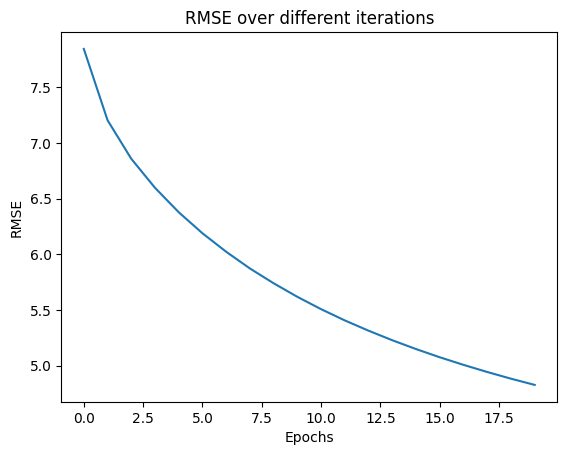

In [10]:
# Danh sách để lưu trữ giá trị RMSE cho mỗi cấu hình
rmse_values = []
epochs = 20

# Chạy mô hình với các số vòng lặp khác nhau
for epoch in range(1,epochs+1):
    als = ALS(maxIter=epoch, regParam=0.01, userCol="user_index", itemCol="movie_id", ratingCol="rating", coldStartStrategy="drop")
    model = als.fit(training)

    # Dự đoán và tính toán RMSE
    predictions = model.transform(test)
    evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    
    if epoch == 1 or epoch % 2 == 0:
        print(f"Epoch: {epoch:>3} |    RMSE: {rmse}")
    # Lưu giá trị RMSE vào danh sách rmse_values
    rmse_values.append(rmse)
rmse_avg = sum(rmse for rmse in rmse_values) / len(rmse_values)

print(f"Giá trị trung bình của RMSE: {rmse_avg}")
# Vẽ đồ thị RMSE theo số vòng lặp
plt.plot(rmse_values)
plt.title("RMSE over different iterations")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.show()

1. RMSE qua từng epoch

- Giai đoạn giảm mạnh ban đầu (Epoch 1-4): 
    RMSE giảm từ 7.846 xuống 6.598, cho thấy mô hình nhanh chóng học được các đặc điểm chính từ dữ liệu. Đây là giai đoạn học sâu đầu tiên, nơi mô hình giảm được các lỗi cơ bản trong dự đoán.

- Giai đoạn giảm dần đều (Epoch 6-10): 
    RMSE giảm từ 6.18 xuống 5.61. Tốc độ giảm chậm hơn, điều này thường xảy ra khi mô hình bắt đầu tối ưu hóa trên các phần chi tiết hơn của dữ liệu.

- Giai đoạn hội tụ (Epoch 12-20): 
    RMSE giảm từ 5.40 xuống 4.82. Mức giảm nhỏ hơn, cho thấy mô hình đã gần đạt đến mức tối ưu và hội tụ tốt.

2. Phân tích biểu đồ RMSE

- Xu hướng: 
    Biểu đồ RMSE giảm dần một cách đều đặn, không có dấu hiệu tăng đột ngột hoặc dao động lớn, chứng minh tính ổn định của thuật toán ALS.

- Đường cong giảm chậm dần: 
    Ban đầu, RMSE giảm nhanh, đặc biệt trong 5-8 epoch đầu tiên, sau đó tốc độ giảm trở nên chậm hơn (phẳng dần) từ epoch 10 trở đi. Điều này phù hợp với quá trình tối ưu hóa thông thường khi mô hình tiến đến hội tụ.

3. Kết luận tổng quan

- Hiệu suất mô hình: 
    Với giá trị RMSE giảm từ 7.846 (epoch 1) xuống 4.827 (epoch 20) và trung bình RMSE là 5.784, mô hình đã học hiệu quả từ dữ liệu và hội tụ tốt.

- Hội tụ ổn định: 
    Biểu đồ minh họa rằng mô hình không gặp vấn đề như overfitting hay underfitting. Việc RMSE tiếp tục giảm trong các epoch cuối cùng cho thấy mô hình vẫn còn tiềm năng học thêm.

### 2.2. Hệ thống gợi ý phim

In [11]:
# Người dùng có user_id = 13
user_id_input = 13
user_id = rating_df.select("user_id").filter(col("user_index") == user_id_input).first()
print(f'Top 10 bộ phim được gợi ý cho người dùng {user_id["user_id"]}:')
# Tạo danh sách 10 bộ phim được đề xuất cho tất cả người dùng
userRecs = model.recommendForAllUsers(10)
# Lọc danh sách các đề xuất cho user_id cụ thể
user_specific_recs = userRecs.filter(col("user_index") == user_id_input)

# Tách cột 'recommendations' và tách thành cột 'movie_id' và 'rating'
user_specific_recs = user_specific_recs.select("user_index", "recommendations") \
    .rdd.flatMap(lambda x: x[1]) \
    .toDF(["movie_id", "rating"])

# Kết hợp thông tin phim dựa trên movie_id để có thêm chi tiết
movie_recs_with_info = user_specific_recs.join(new_movie_df, user_specific_recs["movie_id"] == new_movie_df["id"]) \
    .select(  # Lựa chọn các cột cần thiết để hiển thị
        user_specific_recs["movie_id"], 
        new_movie_df["title"], 
        new_movie_df["original_language"],
        new_movie_df["vote_average"], 
        new_movie_df["runtime"],
        new_movie_df["genres"], 
        new_movie_df["release_year"]
    )
# Hiển thị danh sách các bộ phim được đề xuất cùng thông tin chi tiết
movie_recs_with_info.show()

Top 10 bộ phim được gợi ý cho người dùng Dark Jedi:


+--------+--------------------+-----------------+------------+-------+--------------------+------------+
|movie_id|               title|original_language|vote_average|runtime|              genres|release_year|
+--------+--------------------+-----------------+------------+-------+--------------------+------------+
|  333484|The Magnificent S...|               en|         6.5|    132|[Action, Adventur...|        2016|
|     155|     The Dark Knight|               en|         8.5|    152|[Thriller, Action...|        2008|
|   68718|    Django Unchained|               en|         8.2|    165|    [Drama, Western]|        2012|
|  333339|    Ready Player One|               en|         7.6|    140|[Action, Adventur...|        2018|
|     755| From Dusk Till Dawn|               en|         7.0|    108|[Thriller, Action...|        1996|
|  339964|Valerian and the ...|               en|         6.6|    137|[Action, Adventur...|        2017|
|   11622| Blast from the Past|               en|      

## 3. SGD (Stochastic gradient descent)

### 3.1. Huấn luyện và kiếm tra mô hình.

In [12]:
# Sử dụng StringIndexer để chuẩn hóa các chỉ số và phim
movie_indexer = StringIndexer(inputCol="movie_id", outputCol="movie_index")
# Áp dụng StringIndexer cho cả hai cột và movie_id
rating_df = movie_indexer.fit(rating_df).transform(rating_df)

In [13]:
# Chia dữ liệu thành 80% cho tập train và 20% cho tập test
train_data, test_data = rating_df.randomSplit([0.8, 0.2])

# Lấy số lượng người dùng và phim từ các chỉ số mới
num_users = rating_df.select("user_index").distinct().count()  # Số lượng người dùng
num_movies = rating_df.select("movie_index").distinct().count()  # Số lượng phim

num_latent_features = 10  # Số lượng đặc trưng tiềm ẩn
P = np.random.rand(num_users, num_latent_features) * 0.1
Q = np.random.rand(num_movies, num_latent_features) * 0.1

Huấn luyện, đánh giá mô hình và tính giá trị RMSE

Xây dựng các vector và hàm cập nhật giá trị

In [14]:
# Tốc độ học (learning rate), hệ số điều chuẩn (regularization) và số vòng lặp (epochs)
learning_rate = 0.01
regularization = 0.01
epochs = 50
rmse_train_list = []
# Hàm cập nhật
def update(row):
    user, movie, rating = row
    pred = np.dot(P[user], Q[movie])  # Tính điểm dự đoán (dot product giữa vector người dùng và vector phim)
    error = rating - pred  # Tính lỗi dự đoán (rating thật - dự đoán)

    # Cập nhật vector người dùng và vector phim bằng SGD
    P[user] += learning_rate * (error * Q[movie] - regularization * P[user])
    Q[movie] += learning_rate * (error * P[user] - regularization * Q[movie])

    return user, movie, rating, P, Q, error**2

Huấn luyện mô hình và vẽ đồ thị

Epoch:   0 | RMSE: 5.6716062023558775


Epoch:   5 | RMSE: 2.9486976355094137


Epoch:  10 | RMSE: 2.20581378798701


Epoch:  15 | RMSE: 1.7273999378244254


Epoch:  20 | RMSE: 1.3794408257628374


Epoch:  25 | RMSE: 1.0924914590545276


Epoch:  30 | RMSE: 0.8181740003591865


Epoch:  35 | RMSE: 0.587268893300057


Epoch:  40 | RMSE: 0.42673406283694854


Epoch:  45 | RMSE: 0.31997153939888606


Giá trị trung bình của RMSE: 1.4467600128578855


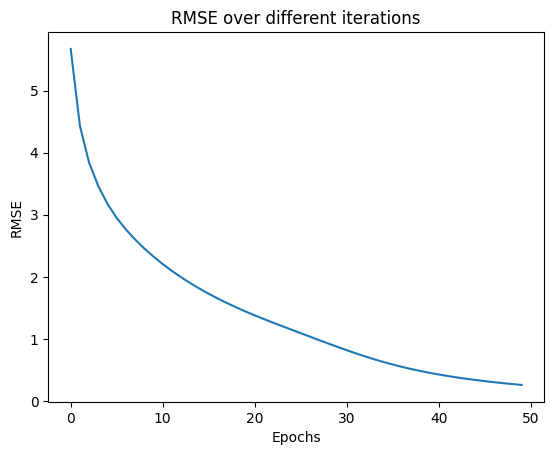

In [15]:
#SGD training
# Chuyển tập train_data thành RDD
train_rdd = train_data.rdd.map(lambda row: (int(row["user_index"]), int(row["movie_index"]), float(row["rating"])))
# Vòng lặp qua các epoch
for epoch in range(epochs):
    train_rdd = train_rdd.map(lambda row: (
        row[0],  # user_index
        row[1],  # movie_index
        row[2]   # rating
        )).map(update)
    rmse_train = sqrt(train_rdd.map(lambda row: (row[2] - np.dot(P[row[0]], Q[row[1]])) ** 2).mean())
    rmse_train_list.append(rmse_train)
    # Hiển thị thông tin
    if epoch % 5 == 0:
        print(f"Epoch: {epoch:>3} | RMSE: {rmse_train}")

# Tính giá trị trung bình của RMSE qua tất cả các epoch
rmse_avg = sum(rmse_train_list) / len(rmse_train_list)
print(f"Giá trị trung bình của RMSE: {rmse_avg}")

# Vẽ đồ thị RMSE qua các vòng lặp
plt.plot(rmse_train_list)
plt.title("RMSE over different iterations")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.show()

1. RMSE qua từng epoch
- Epoch 0-5:
    RMSE giảm mạnh từ 5.67 xuống 2.95, cho thấy mô hình nhanh chóng học được các đặc điểm chính của dữ liệu trong các bước đầu tiên.

- Epoch 10-20:
    RMSE giảm đều từ 2.20 xuống 1.37, tốc độ giảm bắt đầu chậm hơn so với giai đoạn đầu. Đây là giai đoạn mô hình dần tiến gần đến hội tụ.

- Epoch 25-45:
    RMSE tiếp tục giảm rõ rệt, từ 1.09 xuống 0.31. Mô hình đạt hiệu suất rất cao và tiến gần đến giá trị tối ưu, như biểu đồ minh họa.

- Trung bình RMSE:
    Giá trị trung bình 1.4476 là kết quả tốt hơn nhiều so với mô hình ALS trước đó, cho thấy SGD phù hợp hơn với bài toán cụ thể này.

2. Phân tích biểu đồ RMSE
- Xu hướng giảm mạnh:
    Biểu đồ RMSE giảm liên tục và dần tiến đến mức phẳng hơn ở các epoch cuối (từ epoch 35 trở đi). Điều này cho thấy mô hình SGD học hiệu quả và không gặp vấn đề như overfitting hoặc underfitting.

- Giai đoạn hội tụ:
    Biểu đồ có độ dốc cao ở giai đoạn đầu và giảm dần tốc độ khi tiến đến gần epoch 45. Điều này là dấu hiệu của việc SGD hội tụ đúng cách.

3. Đánh giá tổng quan
- Mô hình SGD trong trường hợp này vượt trội hơn về hiệu suất so với ALS (so sánh dựa trên trung bình RMSE).
- Hiệu suất RMSE cuối:
    - SGD đạt 0.3199 (epoch 45), rất thấp và có độ chính xác cao.
    - Đây là mức hiệu suất tốt, thường phù hợp với các bài toán yêu cầu độ chính xác cao.

4. Kết luận
- Mô hình SGD thể hiện tốt với giá trị RMSE thấp và biểu đồ hội tụ ổn định.

In [16]:
# Đánh giá trên tập test
test_rdd = test_data.rdd.map(lambda row: (int(row["user_index"]), int(row["movie_index"]), float(row["rating"])))
# Tính RMSE trên tập test bằng cách lấy trung bình bình phương lỗi dự đoán.
rmse_test = sqrt(test_rdd.map(lambda row: (row[2] - np.dot(P[row[0]], Q[row[1]])) ** 2).mean())
print(f"Test RMSE: {rmse_test}")

Test RMSE: 6.891187700025235


### 3.2. Xây dựng hệ thống gợi ý phim

In [17]:
# Gợi ý phim cho người dùng
def recommend_movies(user_id, P, Q, top_n):
    # Lấy vector ẩn (latent vector) của người dùng.
    user_vector = P[user_id]
    # Tính điểm dự đoán cho tất cả các phim bằng cách nhân vector phim với vector người dùng.
    scores = np.dot(Q, user_vector)
    # Sắp xếp điểm theo thứ tự giảm dần và lấy top_n phim có điểm cao nhất.
    recommended_movies = np.argsort(scores)[::-1][:top_n]
    return recommended_movies

In [18]:
user_id_input = 13 
user_id = rating_df.select("user_id").filter(col("user_index") == user_id_input).first()
# Gợi ý 10 bộ phim cho người dùng bằng hàm recommend_movies.
print(f'Top 10 bộ phim được gợi ý cho người dùng {user_id["user_id"]}:')
recommended_movies = recommend_movies(user_id_input, P, Q, 10)
recommended_movie_list = []
for i in recommended_movies:
    row = rating_df.select("movie_id").filter(col("movie_index") == i).first()
    movie = int(row["movie_id"])
    recommended_movie_list.append(movie)
# Tạo DataFrame chỉ chứa các movie_id được gợi ý
recommended_df = spark.createDataFrame([(movie_id,) for movie_id in recommended_movie_list], ["movie_id"])
# Chuyển danh sách các movie_id được gợi ý thành DataFrame.
movie_recs_with_info = recommended_df.join(new_movie_df, recommended_df["movie_id"] == new_movie_df["id"]) \
    .select(  
        recommended_df["movie_id"], 
        new_movie_df["title"], 
        new_movie_df["original_language"],
        new_movie_df["vote_average"], 
        new_movie_df["runtime"],
        new_movie_df["genres"], 
        new_movie_df["release_year"]
    )
movie_recs_with_info.show()

Top 10 bộ phim được gợi ý cho người dùng Dark Jedi:
+--------+--------------------+-----------------+------------+-------+--------------------+------------+
|movie_id|               title|original_language|vote_average|runtime|              genres|release_year|
+--------+--------------------+-----------------+------------+-------+--------------------+------------+
|  418078|   It Comes at Night|               en|         5.9|     91|[Drama, Horror, M...|        2017|
|    1576|       Resident Evil|               en|         6.6|    100|[Action, Science ...|        2002|
|  997120|Sniper: Rogue Mis...|               en|         6.3|     96|[Thriller, Action...|        2022|
| 1184918|      The Wild Robot|               en|         8.4|    102|[Action, Science ...|        2024|
|   11568| Blues Brothers 2000|               en|         5.3|    123|[Action, Crime, C...|        1998|
|  787752|               Fresh|               en|         7.0|    115|  [Thriller, Horror]|        2022|
|  

In [19]:
# Dừng Spark session
spark.stop()

# 4.  Kết luận

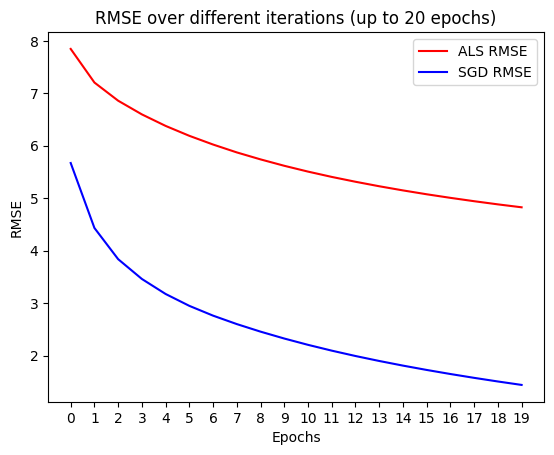

In [30]:
# Cắt dữ liệu chỉ lấy đến vòng lặp thứ 20
rmse_values_20 = rmse_values[:20]
rmse_train_list_20 = rmse_train_list[:20]

# Vẽ đồ thị
plt.plot(rmse_values_20, label="ALS RMSE", color='red')  # Đường màu đỏ
plt.plot(rmse_train_list_20, label="SGD RMSE", color='blue')  # Đường màu xanh
# Thiết lập trục X là các số nguyên
plt.xticks(range(20))  # Đảm bảo trục X chỉ hiển thị các số nguyên

plt.title("RMSE over different iterations (up to 20 epochs)")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

Bảng so sánh dữ trên đồ thị kết quả RMSE của 2 mô hình
| **Tiêu chí**                  | **Mô hình ALS**                                     | **Mô hình SGD**                                   |
|-------------------------------|----------------------------------------------------|--------------------------------------------------|
| **Giá trị RMSE ban đầu**      | 7.846 (epoch 1)                                    | 5.671 (epoch 0)                                  |
| **Giá trị RMSE cuối**         | 4.827 (epoch 20)                                   | 0.320 (epoch 45)                                 |
| **RMSE trung bình**           | 5.784                                              | 1.447                                            |
| **Số epoch tối đa**           | 20                                                 | 45                                               |
| **Xu hướng hội tụ**           | Giảm ổn định, hội tụ chậm dần ở epoch cuối.         | Giảm nhanh hơn, hội tụ sớm hơn.                 |
| **Độ ổn định của RMSE**       | Ổn định nhưng giảm chậm ở các epoch cuối.           | Ổn định và giảm mạnh đến cuối.                   |
| **Hiệu suất dự đoán**         | Trung bình                                         | Cao (RMSE nhỏ hơn đáng kể).                      |
| **Thời gian đào tạo**         | Nhanh hơn.                                          |      Chậm hơn.                                  |


Bảng kết luận
| **Tiêu chí**                  | **Mô hình ALS**                                                                                     | **Mô hình SGD**                                                                      |
|-------------------------------|----------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------|
| **Khả năng xử lý dữ liệu lớn** | **Vượt trội**: Tận dụng tốt các framework như Spark để xử lý dữ liệu phân tán, tối ưu cho dữ liệu lớn. | **Hạn chế**: Xử lý tuần tự, cần lưu trữ toàn bộ dữ liệu trong bộ nhớ, dễ gặp vấn đề với Big Data. |
| **Hiệu quả trên dữ liệu thưa** | **Rất tốt**: Tự nhiên phù hợp với ma trận thưa nhờ kỹ thuật phân tích ma trận.                      | **Trung bình**: Cần tối ưu từng cặp dữ liệu, thời gian đào tạo lâu hơn với dữ liệu thưa. |
| **Hỗ trợ tính toán phân tán**  | **Rất tốt**: Được thiết kế để chạy song song và phân tán (Spark MLlib, Hadoop).                    | **Hạn chế**: Không hỗ trợ tính toán phân tán tự nhiên, thường chạy trên một máy chủ đơn lẻ. |
| **Tốc độ hội tụ**              | **Nhanh với dữ liệu lớn**: Hội tụ nhanh nhờ giải trực tiếp bài toán tối ưu bậc hai (Least Squares). | **Chậm hơn với dữ liệu lớn**: Cần nhiều epoch hơn để hội tụ, do tối ưu theo từng bước nhỏ. |
| **Yêu cầu bộ nhớ**             | **Tiết kiệm bộ nhớ** khi kết hợp với phân tán, nhưng yêu cầu framework hỗ trợ.                     | **Cao**: Dữ liệu lớn cần lưu trữ trong bộ nhớ, gây quá tải nếu không đủ tài nguyên.    |
| **Độ chính xác trên dữ liệu lớn** | **Tốt**: Thích hợp cho dữ liệu lớn và phức tạp, đạt hiệu quả đủ tốt với thông số phù hợp.           | **Rất tốt**: Với dữ liệu nhỏ, SGD có thể đạt chính xác cao hơn.                      |
| **Tùy chỉnh hàm mất mát**      | **Hạn chế**: Chỉ hỗ trợ tối ưu hóa bằng Least Squares Loss.                                        | **Linh hoạt**: Hỗ trợ nhiều loại hàm mất mát, tùy chỉnh cho từng bài toán.           |
| **Ứng dụng thực tế**           | Hệ thống gợi ý, xử lý dữ liệu lớn, đặc biệt là với các tập dữ liệu thưa (hệ thống đề xuất phim/sản phẩm). | Các bài toán nhỏ, yêu cầu tùy chỉnh cao hoặc xử lý dữ liệu đặc thù (như học sâu, dữ liệu liên tục). |
